In [1]:
#Masking Raster with shapefile

In [80]:
import rasterio.mask
import fiona
import rasterio
import geopandas as gpd
from osgeo import ogr, gdal
from osgeo import gdal_array
from osgeo import gdalconst


In [81]:
#Setting path to directory

def get_rooted(stem):
    return "F:/AV Consulting/2022/LiLa/TN Government/Data/LiLa_Nagapattinam/" + stem

def read_raster_UT(stem):
    return rasterio.open(get_rooted(stem))

def read_shpfi_UT(stem):
    return fiona.open(get_rooted(stem))    

def read_rastergpd_UT(stem):
    return gpd.read_file(get_rooted(stem)) 

def read_rastergdal_UT(stem):
    return gdal.Open(get_rooted(stem))    

    

In [4]:
#Open Shapefile with fiona

In [5]:
with read_shpfi_UT('Practice/Nagapattinam_proj32644.shp') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]



In [6]:
#Coordinate Reference System of Shapefile

read_shpfi_UT('Practice/Nagapattinam_proj32644.shp').crs

{'init': 'epsg:32644'}

In [7]:
#Open Raster #with rasterio

In [8]:
with read_raster_UT('Supporting _info/DEM_T44PLT_proj32644_filled_slope.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta

In [9]:
#Coordinate Reference System of Shapefile

read_raster_UT('Supporting _info/DEM_T44PLT_proj32644_filled_slope.tif').crs

CRS.from_epsg(32644)

In [10]:
out_meta.update({
    'driver':'Gtiff',
    'height': out_image.shape[1],
    'width': out_image.shape[2],
    'transform': out_transform,
})    

In [11]:
out_meta = src.meta

In [12]:
with rasterio.open('F:/AV Consulting/2022/LiLa/TN Government/Data/LiLa_Nagapattinam/workdir/Outputslope_rasternagapattinam_slope.tif', 'w', **out_meta) as dst:
    dst.write(out_image)

In [13]:
import rasterio.plot

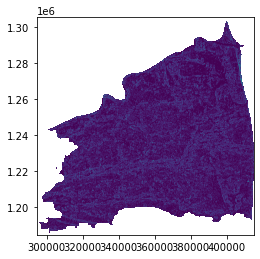

<AxesSubplot:>

In [14]:
rasterio.plot.show(read_raster_UT('workdir/Outputslope_rasternagapattinam_slope.tif'))

Converting raster into epsg 4326 CRS

In [15]:
#Open raster
_tif_dst_slope = read_raster_UT('workdir/Outputslope_rasternagapattinam_slope.tif')

In [16]:
#Show the CRS of source raster
_tif_dst_slope.crs

CRS.from_epsg(32644)

In [17]:
#Defining CRS of reprojected raster. Reprojected raster is named _tif_dst_slope_epsg4326
_tif_dst_slope_epsg4326 = {'init': 'EPSG:4326'}

In [18]:
#Calculate transform array and shape of reprojected raster
from rasterio.warp import calculate_default_transform, reproject, Resampling
transform, width, height = calculate_default_transform(
    _tif_dst_slope.crs, _tif_dst_slope_epsg4326, _tif_dst_slope.width, _tif_dst_slope.height, *_tif_dst_slope.bounds)

_tif_dst_slope.transform
transform

Affine(0.000277793532252525, 0.0, 79.11307386302434,
       0.0, -0.000277793532252525, 11.808617073476151)

In [19]:
#Working of the meta for the destination raster
kwargs = _tif_dst_slope.meta.copy()
kwargs.update({
        'crs': _tif_dst_slope_epsg4326,
        'transform': transform,
        'width': width,
        'height': height,
    })

In [20]:
#Open destination raster
_tif_dst_slope_epsg4326 = rasterio.open(
    'F:/AV Consulting/2022/LiLa/TN Government/Data/LiLa_Nagapattinam/workdir/Outputslope_rst_dst_epsg4326.tif', 'w', **kwargs)


In [21]:
#Reproject and save raster band date
for i in range(1, _tif_dst_slope.count + 1):
    reproject(
        source = rasterio.band(_tif_dst_slope, i),
        destination = rasterio.band(_tif_dst_slope_epsg4326, i),
        src_crs = _tif_dst_slope.crs,
        dst_crs = _tif_dst_slope_epsg4326,
        resampling = Resampling.nearest
    )


In [22]:
_tif_dst_slope_epsg4326.close()

In [23]:
from rasterio.plot import show

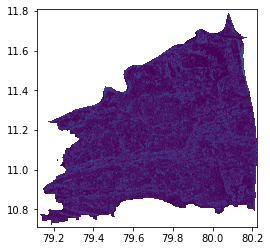

<AxesSubplot:>

In [24]:
_tif_dst_slope_epsg4326 = read_raster_UT('workdir/Outputslope_rst_dst_epsg4326.tif')
show(_tif_dst_slope_epsg4326)

In [25]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from osgeo import ogr, gdal
from osgeo import gdal_array
from osgeo import gdalconst

In [26]:
array = _tif_dst_slope_epsg4326.read()
array.shape
#raster shape is given as (band, rows, columns)

(1, 3946, 3993)

In [27]:
_tif_dst_slope_epsg4326.colorinterp[0]

<ColorInterp.gray: 1>

In [28]:
_tif_dst_slope_epsg4326_meta =_tif_dst_slope_epsg4326.meta
print(_tif_dst_slope_epsg4326_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3993, 'height': 3946, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.000277793532252525, 0.0, 79.11307386302434,
       0.0, -0.000277793532252525, 11.808617073476151)}


## Slope Raster

To visualize raster, information was used from:

https://zia207.github.io/geospatial-python.io/lesson_06_working-with-raster-data.html

https://stackoverflow.com/questions/61327088/rio-plot-show-with-colorbar

https://matplotlib.org/stable/api/axis_api.html


In [82]:
gdal_data = read_rastergdal_UT('workdir/Outputslope_rst_dst_epsg4326.tif')
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan
    data_array[data_array == nodataval] = np.nan

C:\Users\Katya\AppData\Local\Temp\ipykernel_20004\3228411111.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_array = gdal_data.ReadAsArray().astype(np.float)


To create color map:

Visit: https://www.delftstack.com/howto/matplotlib/custom-colormap-using-python-matplotlib/

Visit: https://www.youtube.com/watch?v=qk0n-YaKIkY

The line that creates the colormap is: 

name_of_cmap = LinearSegmentedColormap.from_list('name of this color string', colors=['starting color in hexcode','ending color in hexcode'], N=steps in color of which max is 256)

Ex: AVC_color = LinearSegmentedColormap.from_list('testCmap', colors=['#ec6669','#FFFFFF'], N=256)

There can also be a list of colours for the colourmap, like in the example below

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors
xdata=[1,2,3,4,5,6,7,8,9,10,11,12]
ydata=[x*x for x in xdata]
norm=plt.Normalize(1,150)
colorlist=["darkorange", "gold", "lawngreen", "lightseagreen"]
newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
c=np.linspace(0,300,12)
plt.scatter(xdata,ydata,c=c, cmap=newcmp, norm=norm)
plt.colorbar()
plt.show()

To check color palette created:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#ec6669' #AVC colour
c2='#FFFFFF' #white
n=500

fig, ax = plt.subplots(figsize=(8, 5))
for x in range(n+1):
    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4) 
plt.show()

To check raster with a specific colour map: 

show(rasterfile_name, cmap=nameofdefinedcolourmap)

In [125]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors

#Set colour
AVC_color = LinearSegmentedColormap.from_list('testCmap1', colors=['#ec6669','#FFFFFF'], N=256)


In [76]:
#Show min and max of array without nan values
a = np.nanmax(data_array)
b = np.nanmin(data_array)
a, b

(26.979894638061523, 0.0)

In [90]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter

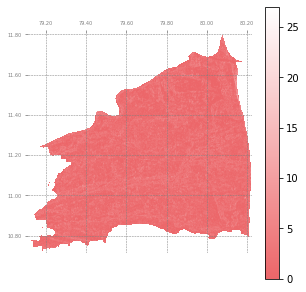

In [126]:
dem = read_raster_UT('workdir/Outputslope_rst_dst_epsg4326.tif')

fig, ax = plt.subplots(figsize=(5, 5))
plt.grid(color="grey",linestyle = '--', linewidth = 0.5)


ax.xaxis.tick_top()

ax.tick_params(axis='x', colors='grey', labelsize=5)
ax.tick_params(axis='y', colors='grey', labelsize=5) #reducing the size of the axis values

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) #axis value formatting for both axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.spines['bottom'].set_color('none')
ax.spines['top'].set_color('none') 
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(data_array, 
                         cmap=AVC_color, 
                         )

# plot on the same axis with rasterio.plot.show
image = rasterio.plot.show(dem, 
                      transform=dem.transform, 
                      ax=ax, 
                      cmap=AVC_color, 
                      )

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

## GHI

In [100]:
GHI_gdal_data = read_rastergdal_UT('workdir/GHIepsg_Nagapattinam.tif')
gdal_band = GHI_gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
GHI_data_array = GHI_gdal_data.ReadAsArray().astype(np.float)
GHI_data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    GHI_data_array[data_array == nodataval] = np.nan
    GHI_data_array[data_array == nodataval] = np.nan

C:\Users\Katya\AppData\Local\Temp\ipykernel_20004\3816486651.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  GHI_data_array = GHI_gdal_data.ReadAsArray().astype(np.float)


In [107]:
#Set colour
AVC_color2 = LinearSegmentedColormap.from_list('testCmap', colors=['#e62314','#f19e18'], N=256)

In [116]:
#Show min and max of array without nan values
a = np.nanmax(GHI_data_array)
b = np.nanmin(GHI_data_array)
a, b

(2016.5450439453125, 1.1754943508222875e-38)

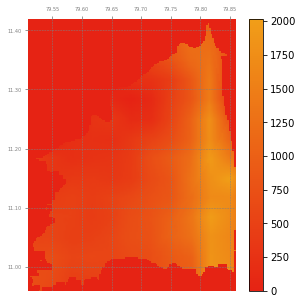

In [131]:
GHI = read_raster_UT('workdir/GHIepsg_Nagapattinam.tif')

fig, ax = plt.subplots(figsize=(5, 5))
plt.grid(color="grey",linestyle = '--', linewidth = 0.5)


ax.xaxis.tick_top()

ax.tick_params(axis='x', colors='grey', labelsize=5)
ax.tick_params(axis='y', colors='grey', labelsize=5) #reducing the size of the axis values

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) #axis value formatting for both axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.spines['bottom'].set_color('none')
ax.spines['top'].set_color('none') 
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(GHI_data_array, 
                         cmap=AVC_color2, 
                         vmin = 1970.524048,
                         vmax = a,
                         )

# plot on the same axis with rasterio.plot.show
image = rasterio.plot.show(GHI, 
                      transform=dem.transform, 
                      ax=ax, 
                      cmap=AVC_color2, 
                      with_bounds = 'True'
                      )

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

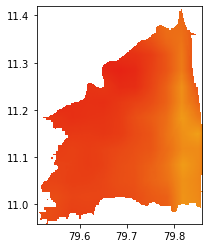

<AxesSubplot:>

In [111]:
show(GHI, cmap=AVC_color2)

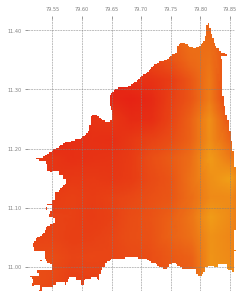

In [123]:
fig, ax = plt.subplots(figsize=(5, 5))

image = rasterio.plot.show(GHI, 
                      transform=dem.transform, 
                      ax=ax, 
                      cmap=AVC_color2, 
                      with_bounds = 'True'
                      )

plt.grid(color="grey",linestyle = '--', linewidth = 0.5)


ax.xaxis.tick_top()

ax.tick_params(axis='x', colors='grey', labelsize=5)
ax.tick_params(axis='y', colors='grey', labelsize=5) #reducing the size of the axis values

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) #axis value formatting for both axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.spines['bottom'].set_color('none')
ax.spines['top'].set_color('none') 
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

